In [10]:
import sys
import os
import psi4
import resp
import rdkit
from openbabel import openbabel as ob
from rdkit import Chem
from rdkit.Chem import AllChem,Draw
import IPython
from IPython.display import Image
# from rdkit.Chem.Draw import IPythonConsole

#@title **Please, provide the necessary input files below**:

#@markdown Type the smiles of your molecule. If you don't know your smiles, please, check at https://pubchem.ncbi.nlm.nih.gov/
Smiles = 'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O' #@param {type:"string"}
smiles_fig = Chem.MolFromSmiles(Smiles)



# Draw.MolToMPL(smiles_fig, size=(200, 200))
smi_end = Draw.MolToFile(smiles_fig, size=(600, 600), filename='smiles.png')
Image('smiles.png')

#print("SMILES:", Smiles)

original_stdout = sys.stdout # Save a reference to the original standard output
final_smiles = 'content/smiles.smi'
with open(final_smiles, 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(Smiles, ' ')
    sys.stdout = original_stdout

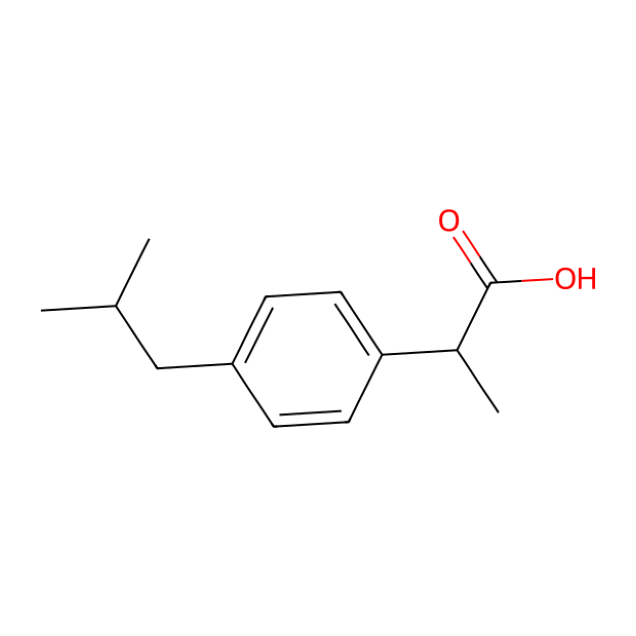

SMILES: CC(C)CC1=CC=C(C=C1)C(C)C(=O)O  



In [11]:
import sys
import os
import IPython
from IPython.display import Image
# from rdkit.Chem.Draw import IPythonConsole

#@title **Check your molecule**:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('smiles.png')
plt.figure(figsize = (8,8))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

# Image('smiles.png')
a_file = open('content/smiles.smi')
file_contents = a_file.read()
print("SMILES:", file_contents)
#print("SMILES:", Smiles)


In [14]:
import os
import psi4
import resp
from openbabel import openbabel as ob
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem,Draw
IPythonConsole.molSize = 250,250

def neutralize_atoms(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return mol

def cleanUp(psi4out_xyz):
    deleteTheseFiles = ['1_default_grid.dat','1_default_grid_esp.dat','grid.dat','timer.dat']
    deleteTheseFiles.append(psi4out_xyz)
    for fileName in deleteTheseFiles:
        if os.path.exists(fileName):
            os.remove(fileName)

def get_xyz_coords(mol):
    if not mol is None:
        num_atoms = mol.GetNumAtoms()
        xyz_string=""
        for counter in range(num_atoms):
            pos=mol.GetConformer().GetAtomPosition(counter)
            xyz_string = xyz_string + ("%s %12.6f %12.6f %12.6f\n" % (mol.GetAtomWithIdx(counter).GetSymbol(), pos.x, pos.y, pos.z) )
    return xyz_string


def calcRESPCharges(mol, basisSet, method, gridPsi4 = 1):
    options = {'BASIS_ESP': basisSet,
               'METHOD_ESP': method,
               'RESP_A': 0.0005,
               'RESP_B': 0.1,
               'VDW_SCALE_FACTORS':[1.4, 1.6, 1.8, 2.0],
               'VDW_POINT_DENSITY':int(gridPsi4)
    }

    # resp_charges = resp.resp([mol], [options])[0][1]
    resp_charges = resp.resp([mol], options)

    return resp_charges

#@title **Parameters to generate partial charges:**


method = "B3LYP" #@param ["B3LYP", "MP2", "HF"]

basisSet = "6-31G**" #@param ["STO-3g", "3-21G", "6-31G*", "6-31G**", "6-31+G(d,p)", "6-311++G(2d,p)"]

Neutralize = "Yes" #@param ["Yes", "No"]

if Neutralize == "Yes":
  neutralize = True
else:
  neutralize = False

Calculation_Type = "Single Point" #@param ["Single Point", "Geometry Optimization"]

if Calculation_Type == "Single Point":
  singlePoint = True
else:
  singlePoint = False

# method = 'b3lyp'
# basisSet = '6-31G**' #'6-31G**' '3-21g'
neutralize = True
psi4.set_memory('8 GB')
obConversion = ob.OBConversion()
obConversion.SetInAndOutFormats("xyz", "mol2")
# singlePoint = True
path = 'content'

# inputFile = '/content/smiles.smi'
# molList = Chem.SDMolSupplier(inputFile, removeHs=False)

SMILESasInput = True

if SMILESasInput:
    molList = []
    inputFile = 'content/smiles.smi'
    suppl = Chem.SmilesMolSupplier(inputFile, titleLine = False)

    for mol in suppl:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        try:
            AllChem.MMFFOptimizeMolecule(mol)
        except:
            AllChem.UFFOptimizeMolecule(mol)
        molList.append(mol)

for mol in molList:
    print(mol)
    if not mol is None:

        molId = mol.GetProp("_Name")
        print('Trying:', molId)

        if neutralize:
            mol = neutralize_atoms(mol)
            mol = Chem.AddHs(mol)

        xyz_string = get_xyz_coords(mol)
        psi_mol = psi4.geometry(xyz_string)

        ### single point calculation
        outfile_mol2 = inputFile[:-4]+".mol2"

        if singlePoint:
            print('Running singlepoint...')
            resp_charges = calcRESPCharges(psi_mol, basisSet, method, gridPsi4 = 1)

        else:
            print('Running geometry optimization...')
            methodNbasisSet = method+"/"+basisSet
            psi4.optimize(methodNbasisSet, molecule=psi_mol)
            resp_charges = calcRESPCharges(psi_mol, basisSet, method, gridPsi4 = 1)

        ### save coords to xyz file
        psi4out_xyz = molId + '.xyz'
        psi_mol.save_xyz_file(psi4out_xyz,1)


        ### read xyz file and write as mol2
        ob_mol = ob.OBMol()
        obConversion.ReadFile(ob_mol, psi4out_xyz)

         ### write as mol2
        outfile_mol2 = path+"/"+molId+"_partialChgs.mol2"
        obConversion.WriteFile(ob_mol, outfile_mol2)

        ### set new partial charges
        count = 0
        newChg_temp = resp_charges[1]
        print("RESP Charges: ", newChg_temp)
        for atom in ob.OBMolAtomIter(ob_mol):
            newChg = newChg_temp[count]
            atom.SetPartialCharge(newChg)
            count += 1

        ### write as mol2
        outfile_mol2 = path+"/"+molId+"_partialChgs.mol2"
        outfile_pdb = path+"/"+molId+".pdb"
        print("Finished. Saved compound with partial charges as mol2 file: %s" % outfile_mol2)
        obConversion.WriteFile(ob_mol, outfile_mol2)
        ## clean up
        cleanUp(psi4out_xyz)

#draw_with_charges
inputFile2 = 'content/smiles.smi'
suppl2 = Chem.SmilesMolSupplier(inputFile2, titleLine = False)
for mol_2 in suppl2:
    m2 = mol_2

for at, i in zip(m2.GetAtoms(), newChg_temp):
    lbl = '%.2f'%(i)
    at.SetProp('atomNote',lbl)
    Draw.MolToFile(m2, size=(600, 600), filename='smiles_charges.png')


  Memory set to   7.451 GiB by Python driver.
Trying: 
Running singlepoint...

*** tstart() called on Barrys-MacBook-Pro.local
*** at Thu Apr 18 19:47:46 2024

   => Libint2 <=

    Primary   basis highest AM E, G, H:  6, 6, 3
    Auxiliary basis highest AM E, G, H:  7, 7, 4
    Onebody   basis highest AM E, G, H:  -, -, -
    Solid Harmonics ordering:            Gaussian
   => Loading Basis Set <=

    Name: 6-31G**
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-13  entry C          line   115 file /opt/anaconda3/envs/psi4/share/psi4/basis/6-31gss.gbs 
    atoms 14-15 entry O          line   149 file /opt/anaconda3/envs/psi4/share/psi4/basis/6-31gss.gbs 
    atoms 16-33 entry H          line    44 file /opt/anaconda3/envs/psi4/share/psi4/basis/6-31gss.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
           

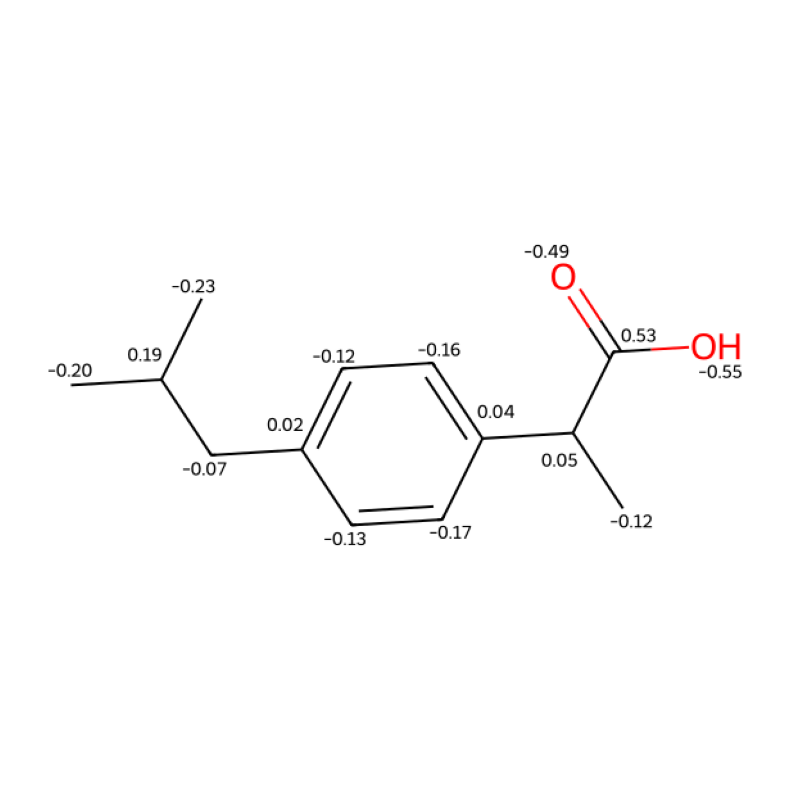

SMILES: CC(C)CC1=CC=C(C=C1)C(C)C(=O)O  



In [15]:
import sys
import os
import IPython
from IPython.display import Image
# from rdkit.Chem.Draw import IPythonConsole

#@title **Check your charges**:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('smiles_charges.png')
plt.figure(figsize = (10,10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

# Image('smiles.png')
a_file = open('content/smiles.smi')
file_contents = a_file.read()
print("SMILES:", file_contents)

In [25]:
#@title **Check your geometry**
import warnings
warnings.filterwarnings('ignore')
import py3Dmol

view = py3Dmol.view(width=800, height=600)
view.addModel(open('content/_partialChgs.mol2','r').read(),'mol2')
view.addStyle({'stick':{'colorscheme':'lightgrayCarbon','radius':0.1}})
view.setViewStyle({'style':'outline','color':'black','width':0.05})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.